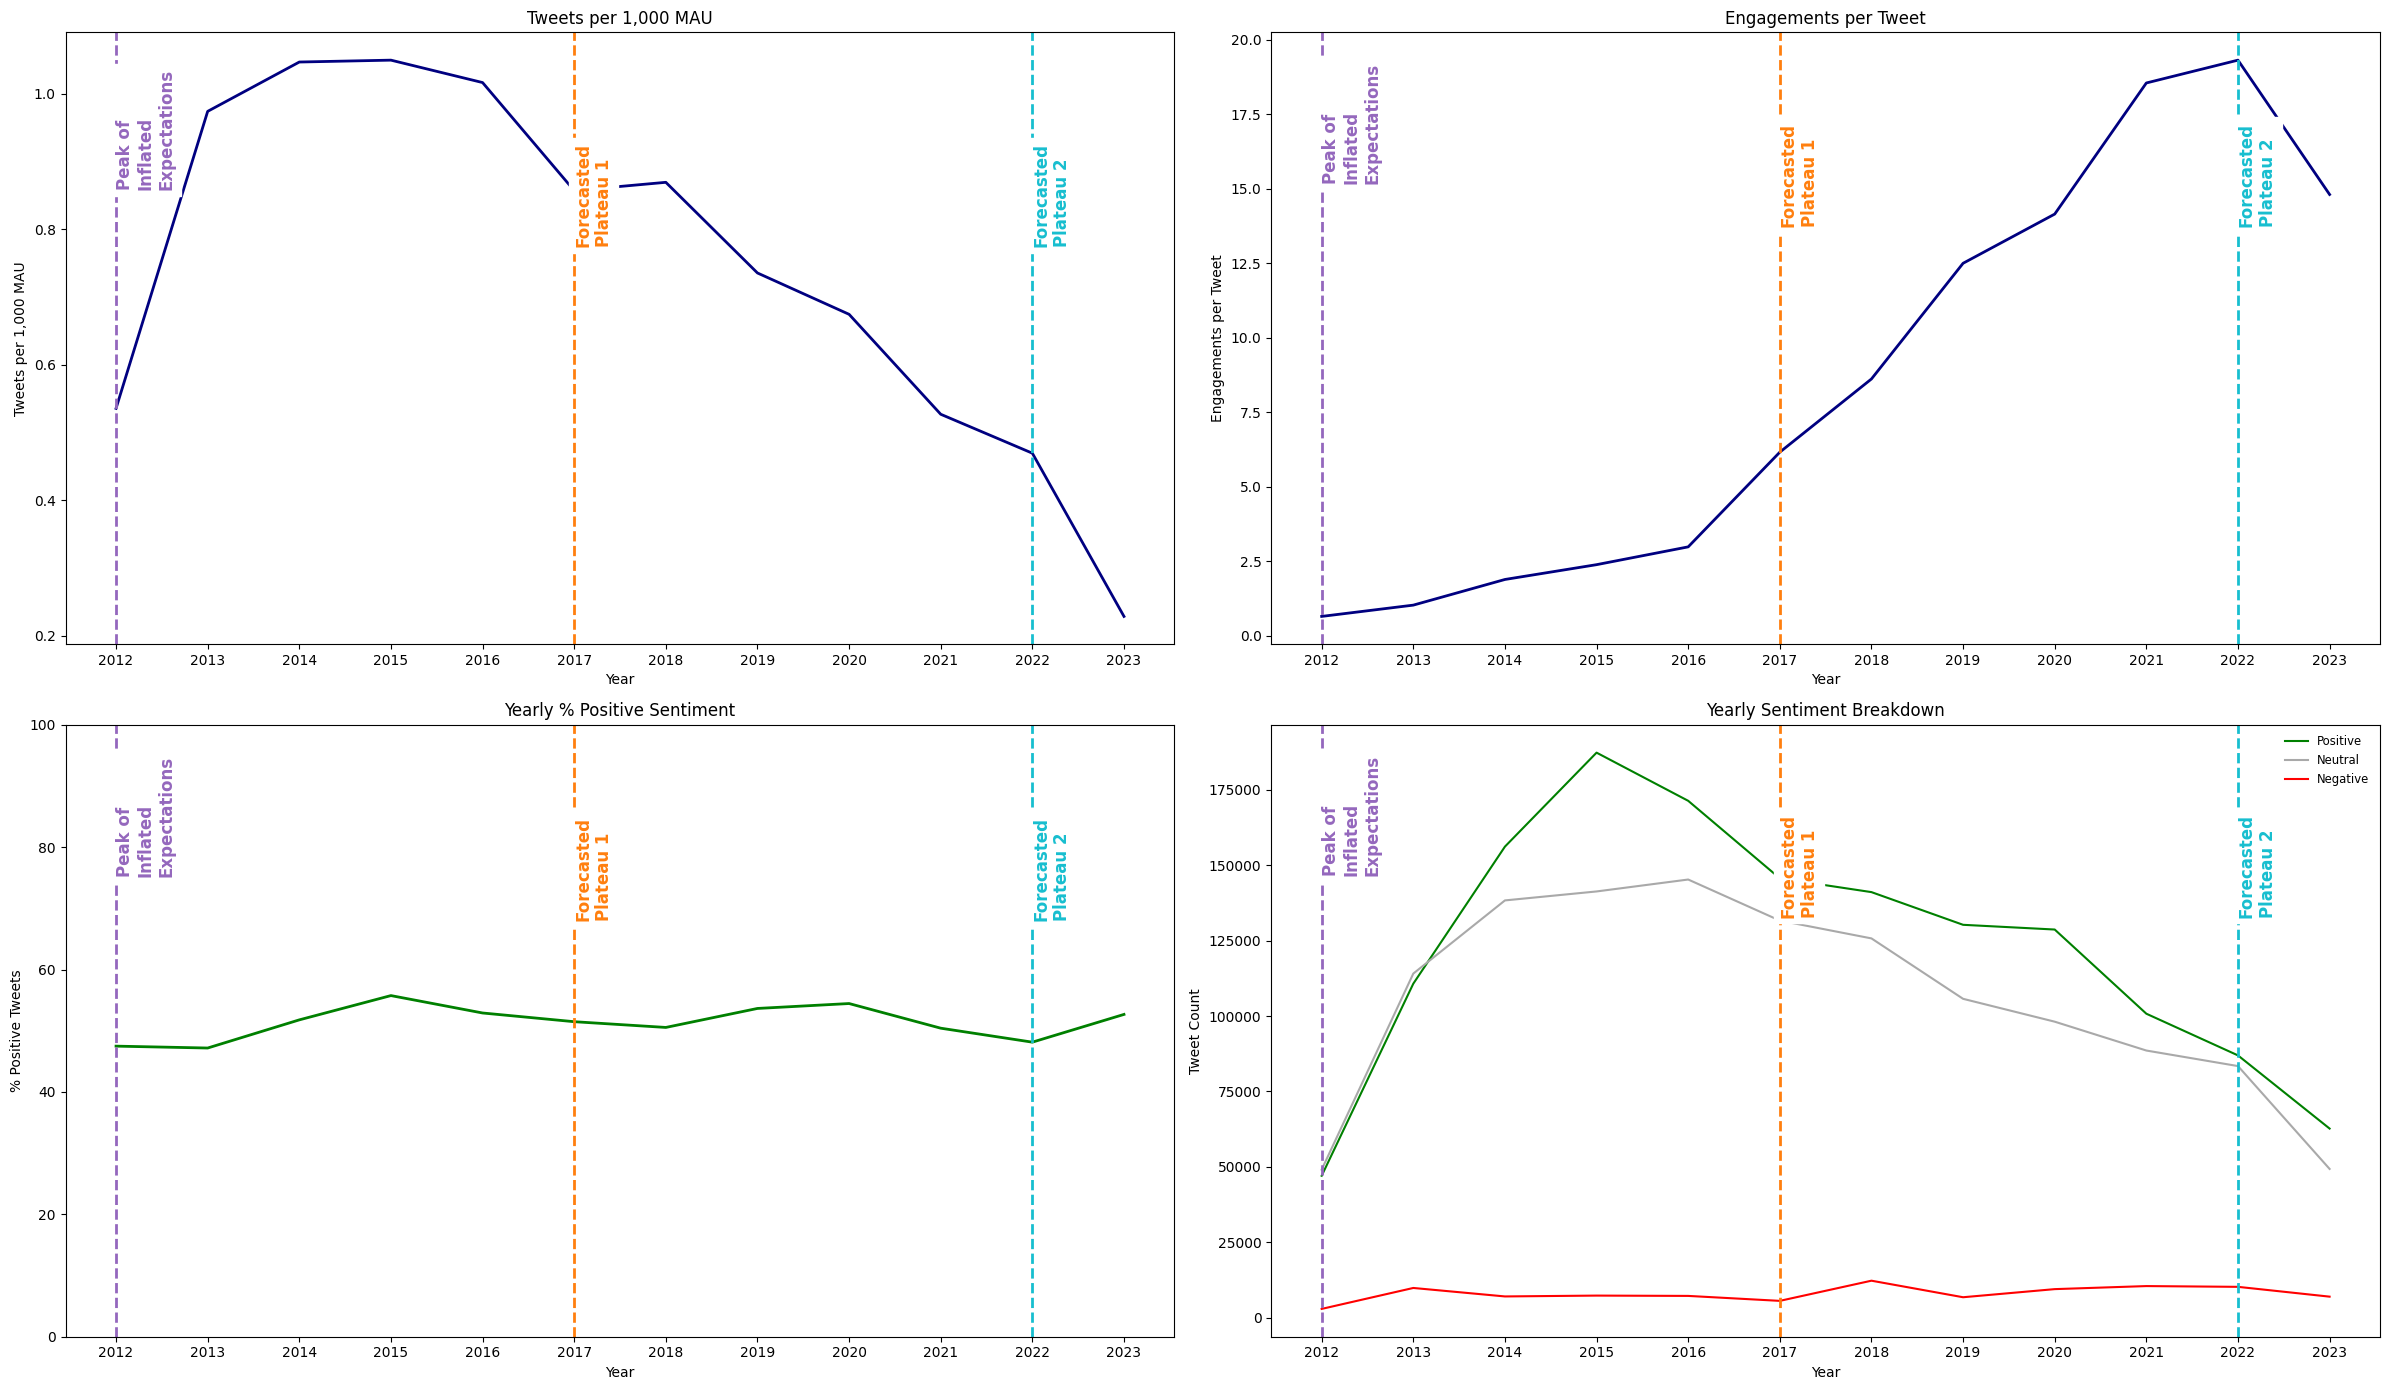

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


tweet_color      = 'navy'
pos_color        = 'green'
neg_color        = 'red'
neu_color        = 'darkgrey'
peak_color       = 'tab:purple'
plateau1_color   = 'tab:orange'
plateau2_color   = 'tab:cyan'

# --- 1) Load & prepare AM dataset ---
df_am = pd.read_csv('CLEANED_DATASET_20250531_004116.csv', parse_dates=['Date'])
df_am['Year'] = df_am['Date'].dt.year
tweets_per_year = df_am.groupby('Year').size().rename('tweet_count')
engagement_per_year = df_am.groupby('Year')['Total Engagement'] \
                          .sum().rename('total_engagement')

mau_estimates = {
    2012: [185], 2013: [240.9], 2014: [288],   2015: [320],
    2016: [319, 318], 2017: [330], 2018: [321], 2019: [330],
    2020: [353, 347.6], 2021: [396, 362.4], 2022: [401, 368.4],
    2023: [541.56, 500]
}
mau_df = pd.DataFrame([
    {'Year': year, 'mau_mean': np.mean(vals) * 1e6}
    for year, vals in mau_estimates.items()
]).set_index('Year')

data = tweets_per_year.to_frame() \
        .join(engagement_per_year) \
        .join(mau_df) \
        .sort_index()
data['tweets_per_1000_mau'] = data['tweet_count'] / data['mau_mean'] * 1000
data['engagement_rate']    = data['total_engagement'] / data['tweet_count']

# --- 2) Load & prepare sentiment data & aggregate yearly ---
df_posts = pd.read_csv(
    "CLEANED_POST-LLM_MERGED_WITH_MASTER_20250603_232236.csv",
    parse_dates=['Date']
)
df_posts['Year'] = df_posts['Date'].dt.year

sent_map = {
    "Positive":"positive","Promotional":"positive","Playful":"positive",
    "Neutral":"neutral","Curious":"neutral","Mixed":"neutral",
    "Surprise":"neutral","Surprise/Neutral":"neutral",
    "Negative":"negative","Skeptical":"negative","Frustrated":"negative",
    "Confused":"negative"
}
df_posts['sentiment_simple'] = df_posts['sentiment'].map(sent_map).fillna('neutral')

sent_yearly = (
    df_posts
    .groupby(['Year','sentiment_simple'])['tweet_id']
    .nunique()
    .unstack(fill_value=0)
)

years = data.index.values

# --- 3) Create larger 2×2 figure and plot ---
fig, axes = plt.subplots(2, 2, figsize=(24, 14))

# Top-left: Tweets per 1,000 MAU
ax = axes[0, 0]
ax.plot(years, data['tweets_per_1000_mau'], '-', color=tweet_color, linewidth=2)
ax.set_title('Tweets per 1,000 MAU')
ax.set_xlabel('Year'); ax.set_ylabel('Tweets per 1,000 MAU')
ax.set_xticks(years)

# Top-right: Engagements per Tweet
ax = axes[0, 1]
ax.plot(years, data['engagement_rate'], '-', color=tweet_color, linewidth=2)
ax.set_title('Engagements per Tweet')
ax.set_xlabel('Year'); ax.set_ylabel('Engagements per Tweet')
ax.set_xticks(years)

# Bottom-left: % Positive Sentiment
ax = axes[1, 0]
total = sent_yearly.sum(axis=1)
pct_pos = sent_yearly['positive'] / total * 100
ax.plot(years, pct_pos.reindex(years), '-', color=pos_color, linewidth=2)
ax.set_title('Yearly % Positive Sentiment')
ax.set_xlabel('Year'); ax.set_ylabel('% Positive Tweets')
ax.set_xticks(years)
ax.set_ylim(0, 100)

# Bottom-right: Raw Sentiment Breakdown
ax = axes[1, 1]
for sentiment, color in [('positive', pos_color),
                         ('neutral',  neu_color),
                         ('negative', neg_color)]:
    ax.plot(years, sent_yearly.reindex(years)[sentiment],
            '-', color=color, label=sentiment.capitalize())
ax.set_title('Yearly Sentiment Breakdown')
ax.set_xlabel('Year'); ax.set_ylabel('Tweet Count')
ax.set_xticks(years)
ax.legend(loc='upper right', fontsize='small', frameon=False)

# --- 4) Add Gartner annotations ---
for ax in axes.flat:
    ax.axvline(2012, linestyle='--', color=peak_color, linewidth=2)
    ax.axvline(2017, linestyle='--', color=plateau1_color, linewidth=2)
    ax.axvline(2022, linestyle='--', color=plateau2_color, linewidth=2)
    ymin, ymax = ax.get_ylim()
    ax.text(2012, ymax*0.95, "Peak of\nInflated\nExpectations",
            rotation=90, ha='left', va='top',
            fontsize=12, fontweight='bold',
            color=peak_color, backgroundcolor='white')
    ax.text(2017, ymax*0.85, "Forecasted\nPlateau 1",
            rotation=90, ha='left', va='top',
            fontsize=12, fontweight='bold',
            color=plateau1_color, backgroundcolor='white')
    ax.text(2022, ymax*0.85, "Forecasted\nPlateau 2",
            rotation=90, ha='left', va='top',
            fontsize=12, fontweight='bold',
            color=plateau2_color, backgroundcolor='white')

plt.tight_layout()

# 4) Save high-resolution image
save_path = 'visualizations/LLM_inference/GARTNER.png'
fig.savefig(save_path, dpi=800, bbox_inches='tight')
